## 使用ESM-1b预训练模型提取特征向量
参考：https://github.com/facebookresearch/esm/blob/c9c7d4f0fec964ce10c3e11dccec6c16edaa5144/scripts/extract.py

In [1]:
DATA_PATH = "../dataset/dataset2.0/" # Path to data
EMBED_PATH =DATA_PATH+'/ESM2_embed/'
EMB_LAYER = 33

In [2]:
import pathlib
import pandas as pd
import torch
import esm
from esm import Alphabet, FastaBatchedDataset, ProteinBertModel, pretrained, MSATransformer


import os

class ProteinExtractionParams:
    def __init__(
        self,
        fasta_file = None,
        csv_file = None,
        output_dir = None,
        toks_per_batch=4096,
        repr_layers=[-1],
        include='mean',
        truncation_seq_length=512,
        nogpu=False,
    ):
        self.fasta_file = fasta_file
        self.csv_file = csv_file

        self.output_dir = pathlib.Path(output_dir)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        self.toks_per_batch = toks_per_batch
        self.repr_layers = repr_layers
        self.include = include
        self.truncation_seq_length = truncation_seq_length
        self.nogpu = nogpu


def run(args):
    model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
    model.eval()
    if isinstance(model, MSATransformer):
        raise ValueError(
            "This script currently does not handle models with MSA input (MSA Transformer)."
        )
    if torch.cuda.is_available() and not args.nogpu:
        model = model.cuda()
        print("Transferred model to GPU")


    if(args.fasta_file):
        dataset = FastaBatchedDataset.from_file(args.fasta_file)
        batches = dataset.get_batch_indices(args.toks_per_batch, extra_toks_per_seq=1)
        data_loader = torch.utils.data.DataLoader(
            dataset, collate_fn=alphabet.get_batch_converter(args.truncation_seq_length), batch_sampler=batches
        )
        print(f"Read {args.fasta_file} with {len(dataset)} sequences")
    elif(args.csv_file):
        data_df = pd.read_csv(args.csv_file)
        
        protein_id = data_df['id']
        # class FastaBatchedDataset(object):
        #     def __init__(self, sequence_labels, sequence_strs):
        #         self.sequence_labels = list(sequence_labels)
        #         self.sequence_strs = list(sequence_strs)
        dataset = FastaBatchedDataset(data_df['id'],data_df['seq'])
        batches = dataset.get_batch_indices(args.toks_per_batch, extra_toks_per_seq=1)
        data_loader = torch.utils.data.DataLoader(
            dataset, collate_fn=alphabet.get_batch_converter(args.truncation_seq_length), batch_sampler=batches
        )
        print(f"Read {args.csv_file} with {len(dataset)} sequences")
    else:
        print('no file!')

    args.output_dir.mkdir(parents=True, exist_ok=True)
    return_contacts = "contacts" in args.include                                                                                                                                

    assert all(-(model.num_layers + 1) <= i <= model.num_layers for i in args.repr_layers)
    repr_layers = [(i + model.num_layers + 1) % (model.num_layers + 1) for i in args.repr_layers]

    with torch.no_grad():
        for batch_idx, (labels, strs, toks) in enumerate(data_loader):
            print(
                f"Processing {batch_idx + 1} of {len(batches)} batches ({toks.size(0)} sequences)"
            )
            if torch.cuda.is_available() and not args.nogpu:
                toks = toks.to(device="cuda", non_blocking=True)

            out = model(toks, repr_layers=repr_layers, return_contacts=return_contacts)

            logits = out["logits"].to(device="cpu")
            representations = {
                layer: t.to(device="cpu") for layer, t in out["representations"].items()
            }
            if return_contacts:
                contacts = out["contacts"].to(device="cpu")

            for i, label in enumerate(labels):
                args.output_file = args.output_dir / f"{label}.pt"
                args.output_file.parent.mkdir(parents=True, exist_ok=True)
                result = {"label": label}
                truncate_len = min(args.truncation_seq_length, len(strs[i]))
                # Call clone on tensors to ensure tensors are not views into a larger representation
                # See https://github.com/pytorch/pytorch/issues/1995
                if "per_tok" in args.include:
                    result["representations"] = {
                        layer: t[i, 1 : truncate_len + 1].clone()
                        for layer, t in representations.items()
                    }
                if "mean" in args.include:
                    result["mean_representations"] = {
                        layer: t[i, 1 : truncate_len + 1].mean(0).clone()
                        for layer, t in representations.items()
                    }
                if "bos" in args.include:
                    result["bos_representations"] = {
                        layer: t[i, 0].clone() for layer, t in representations.items()
                    }
                if return_contacts:
                    result["contacts"] = contacts[i, : truncate_len, : truncate_len].clone()

                torch.save(
                    result,
                    args.output_file,
                )


In [3]:
def extract_embed(data_file):
    input_data  =DATA_PATH+data_file
    output_dir = EMBED_PATH+data_file.split('.')[0]
    args = ProteinExtractionParams(csv_file=input_data,output_dir=output_dir)
    run(args)
    print('Extract ESM embeddings for {}, save in {}'.format(input_data,output_dir))

In [4]:
for file in os.listdir(DATA_PATH):
    if file.endswith('.csv'):
        print(file)
        extract_embed(file)

positive_train_422.csv
Transferred model to GPU
Read ../dataset/dataset2.0/positive_train_422.csv with 422 sequences
Processing 1 of 45 batches (30 sequences)
Processing 2 of 45 batches (22 sequences)
Processing 3 of 45 batches (19 sequences)
Processing 4 of 45 batches (17 sequences)
Processing 5 of 45 batches (16 sequences)
Processing 6 of 45 batches (14 sequences)
Processing 7 of 45 batches (13 sequences)
Processing 8 of 45 batches (12 sequences)
Processing 9 of 45 batches (12 sequences)
Processing 10 of 45 batches (11 sequences)
Processing 11 of 45 batches (11 sequences)
Processing 12 of 45 batches (10 sequences)
Processing 13 of 45 batches (10 sequences)
Processing 14 of 45 batches (10 sequences)
Processing 15 of 45 batches (9 sequences)
Processing 16 of 45 batches (9 sequences)
Processing 17 of 45 batches (9 sequences)
Processing 18 of 45 batches (9 sequences)
Processing 19 of 45 batches (9 sequences)
Processing 20 of 45 batches (9 sequences)
Processing 21 of 45 batches (8 sequenc

In [5]:
# DATA_PATH = "../dataset/dataset2.0/" # Path to data
# EMB_PRE_PATH = "/home/bli/.cache/torch/hub/checkpoints/esm1b_t33_650M_UR50S.pt" 
# EMBED_PATH =DATA_PATH+'/ESM_embed/'
# EMB_LAYER = 33


import os
import torch
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
def load_esm_embed(csv_file):
    Xs = []
    ys = []
    Embed_PATH = EMBED_PATH+csv_file.split('.')[0]
    data_df =  pd.read_csv(DATA_PATH+csv_file)
    for index, row in data_df.iterrows():
        id = row['id']
        label = row['label']

        fn = f'{Embed_PATH}/{id}.pt'
        embs = torch.load(fn)
        Xs.append(embs['mean_representations'][EMB_LAYER])
        ys.append(label)
    Xs = torch.stack(Xs, dim=0).numpy()
    print('load{} esm embedding'.format(csv_file))
    print(len(ys))
    print(Xs.shape)
    return Xs,ys
Xs = []
ys = []
for file in os.listdir(DATA_PATH):
    if file.endswith('.csv'):
        if file.endswith('llpsdb_d.csv'):continue
        x,y = load_esm_embed(file)
        Xs.append(x)
        ys.append(y)
Xs = np.vstack((*Xs,))
ys = [y for sub in ys for y in sub]
print(len(ys))
print(Xs.shape)
num_pca_components = 500
pca = PCA(num_pca_components)
Xs_pca = pca.fit_transform(Xs)

loadpositive_train_422.csv esm embedding
422
(422, 1280)
loadtest_data1_2023-6-9_15_31.csv esm embedding
226
(226, 1280)
loadnegative_train_3307.csv esm embedding
3307
(3307, 1280)
loadtest_data2_2023-6-9_15_31.csv esm embedding
274
(274, 1280)
4229
(4229, 1280)


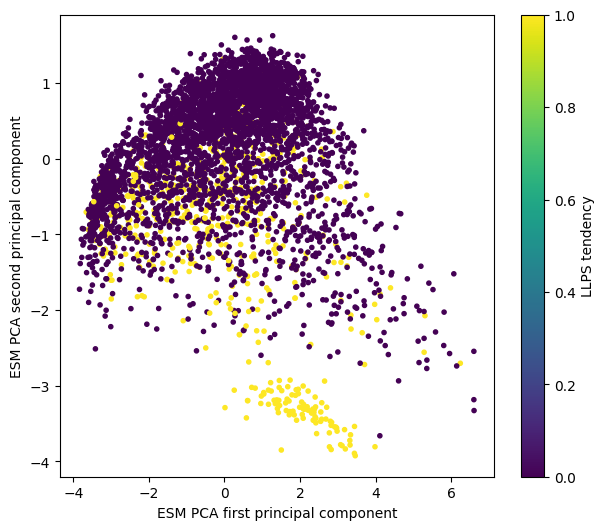

In [6]:
import matplotlib.pyplot as plt
fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_pca[:,0], Xs_pca[:,1], c=ys, marker='.')
ax.set_xlabel('ESM PCA first principal component')
ax.set_ylabel('ESM PCA second principal component')
plt.colorbar(sc, label='LLPS tendency')

<Figure size 1400x1200 with 0 Axes>

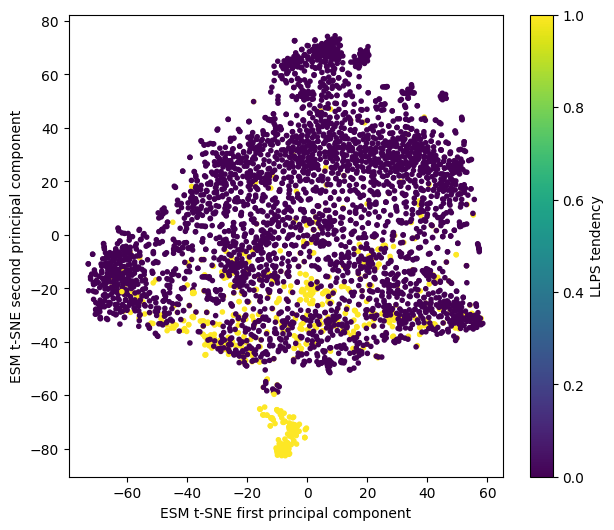

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
X_tsne = TSNE(learning_rate=200.0, n_components=2,perplexity=40, random_state=42).fit_transform(Xs)
# fig_dims = (7, 6)
plt.figure(figsize=(14, 12)) 
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(X_tsne[:,0], X_tsne[:,1], c=ys, marker='.')
ax.set_xlabel('ESM t-SNE first principal component')
ax.set_ylabel('ESM t-SNE second principal component')
plt.colorbar(sc, label='LLPS tendency')
plt.show()

/home/binyun/miniforge3/envs/esm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/binyun/miniforge3/envs/esm/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Figure size 1400x1200 with 0 Axes>

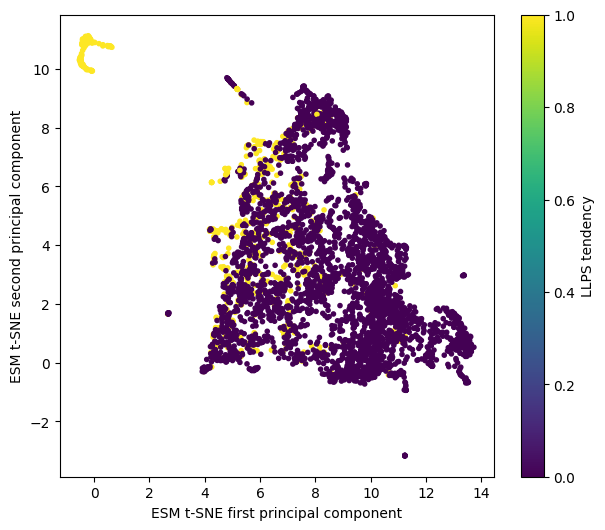

In [11]:
import umap.umap_ as umap
umap_model = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2,random_state=2023)

umap_result = umap_model.fit_transform(Xs)
plt.figure(figsize=(14, 12)) 
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(umap_result[:,0], umap_result[:,1], c=ys, marker='.')
ax.set_xlabel('ESM t-SNE first principal component')
ax.set_ylabel('ESM t-SNE second principal component')
plt.colorbar(sc, label='LLPS tendency')
plt.show()

<Figure size 1400x1200 with 0 Axes>

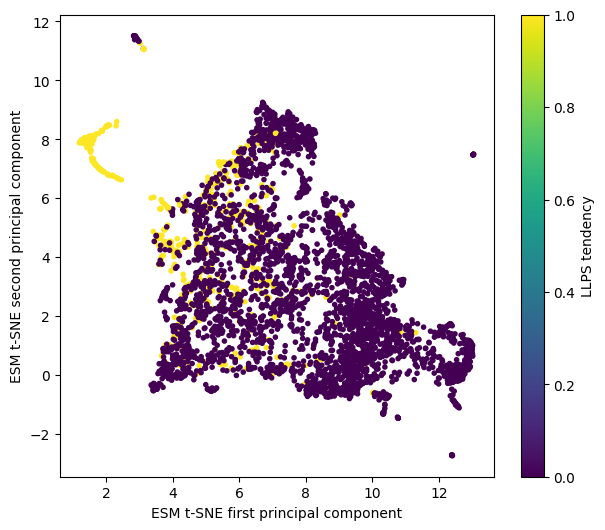

In [12]:
umap_result2 = umap_model.fit_transform(Xs_pca)
plt.figure(figsize=(14, 12)) 
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(umap_result2[:,0], umap_result2[:,1], c=ys, marker='.')
ax.set_xlabel('ESM t-SNE first principal component')
ax.set_ylabel('ESM t-SNE second principal component')
plt.colorbar(sc, label='LLPS tendency')
plt.show()